### Author: Nathaniel Ruhl
### This notebook performs the tanh() fit, reconstructs the curve in the time domain, and performs the curve comparison. Should we also do the curve slide in the altitude domain to get an errorbar for h50, or just use the technique of propogating the variances of each tanh() fit parameter?

Text(0.5, 0, 'Tangent Altitude (km)')

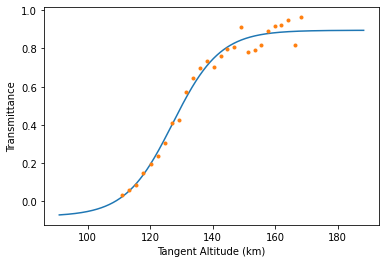

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
%matplotlib inline

R_planet = 6368.16   # km, radius of Earth at tangent point (this is like 'y_0,ref' above)

## It is important to note that the data being readd into this file uses an ellipsoid Earth,
## so we're not looking for exact constistency... just order of magnitude.

timeTransmit = np.load("timeTransmit.npy")
time_data = timeTransmit[:,0]
transmit_data = timeTransmit[:,1]
timeAlt = np.load("timeAlt.npy")
time_crossing_model = timeAlt[:,0]
h_list = timeAlt[:,1]  # Note that this is "h" in my new notation

crossing_range = np.where((time_data>=time_crossing_model[0])&(time_data<=time_crossing_model[-1]))[0]
time_data = time_data[crossing_range]
transmit_data = transmit_data[crossing_range]

# 1) Since the transmit data doesnt correspond to time_crossing_model, we first need to interpolate h_list
# We can avoid this is the future by by definining time_crossing_model differently in another script so that instead of t0_model+[0:175:1], it is t0_model+[dt1:175+dt1:1] where dt1 = time_data[0] - t0_model... but the interpolation is fine for this example
h_vs_time = interp1d(time_crossing_model, h_list, "cubic")
time_vs_h = interp1d(h_list, time_crossing_model, "cubic")
h_data = h_vs_time(time_data)

w1 = np.where(transmit_data>=0.01)[0][0]  # can't go to zero
w2 = np.where(transmit_data >= 0.99)[0][0]  # could also use -1

transmit_measured = transmit_data[w1:w2]
h_measured = h_data[w1:w2]

# Transmittance fit
# we can fit to either y or h, the c parameter is the only thing that will change
def transmit_vs_h(h, a, b, c, d):
    return a*np.tanh(b*(h-c))+d

popt, pcov = curve_fit(transmit_vs_h, h_measured, transmit_measured, p0=[0.5, 1/50, 100, 0.5])
a, b, c, d = popt

h = np.linspace(np.min(h_measured)-20, np.max(h_measured)+20, 1000)
plt.plot(h, transmit_vs_h(h, *popt))
plt.plot(h_measured, transmit_measured, ".")   # fit y, plot h
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")

Reconstruct model in time domain using h50_predict. Note that the model could potentially go negative, so we need to ensure a correct comparison while sliding the curve... we can pretend like we did not previosuly have a weight range and just use comp_range like normal.

Text(0.5, 0, 'Tangent Altitude (km)')

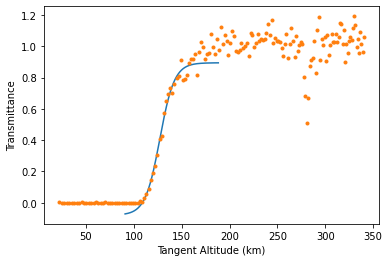

In [2]:
plt.plot(h, transmit_vs_h(h, *popt))
plt.plot(h_data, transmit_data, ".")   # fit y, plot h
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")

[]

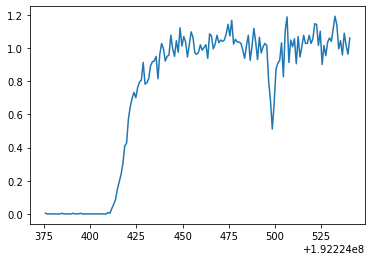

In [3]:
plt.plot(time_data, transmit_data)
plt.plot()

Text(0.5, 1.0, 'Predicted count rate model in time domain (slightly incorrect h_50)')

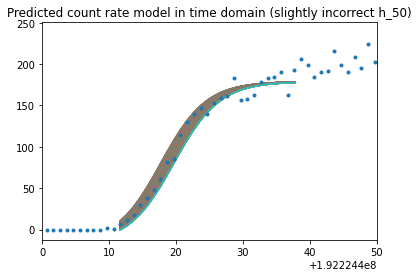

In [8]:
h50_fit = (1/b)*np.arctanh((0.5-d)/a)+c
t50_fit = time_vs_h(h50_fit)    # this  is technically the 50% time measurement
t50_slide_list = np.arange(t50_fit-1, t50_fit+1,0.01)
chisq_list = []
N0=200  # unattenuated count rate
plt.figure()
for t50_i in t50_slide_list:
    h50_i = h_vs_time(t50_i)
    c_i = h50_i - (1/b)*np.arctanh((0.5-d)/a)
    transmit_model = transmit_vs_h(h_measured, a, b, c_i, d)   # T(t) model
    time_model = time_vs_h(h_measured)
    chisq_terms = (N0*transmit_measured - N0*transmit_model)**2/(N0*transmit_model)
    # define comparison range
    comp_range = np.where((transmit_model > 0.01)&(transmit_model<0.99))[0]
    chisq_list.append(np.sum(chisq_terms[comp_range]))
    plt.plot(time_model, N0*transmit_model)
plt.plot(time_data, N0*transmit_data, '.')
plt.xlim([400+1.92224e8,450+1.92224e8])
plt.title("Predicted count rate model in time domain (slightly incorrect h_50)")

192224420.01522273 (rounded to the closest 0.1 sec)
192224420.08522362 (exact)


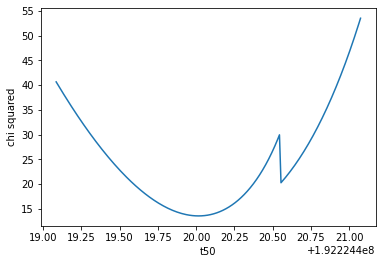

In [9]:
plt.figure()
plt.plot(t50_slide_list, chisq_list)
plt.ylabel("chi squared")
plt.xlabel('t50')
print(t50_slide_list[np.argmin(chisq_list)], "(rounded to the closest 0.1 sec)")
print(t50_fit, "(exact)")
# Note that with Seamus's addition to this algorithm, the two values should be the same

###  Note that index 146 is where comp_range changes by one to remove the point for which the model went negative. This is is why we see the large dip. We should make sure not to accidentally get this as the minimum or included it in the fit